# Determinantes de la oferta monetaria en la economía peruana (2010–2025)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad

# 1. Planteamiento del problema

**Pregunta de investigación:**

¿Cómo influyen la inflación, la tasa de referencia del BCRP y las reservas internacionales netas (RIN) en la evolución de la oferta monetaria (liquidez total) en el Perú durante el período 2022–2025 con datos mensuales?

**Hipótesis teórica:**

* Una mayor inflación afecta positivamente la oferta monetaria, ya que presiona al banco central a incrementar la emisión de dinero para sostener la liquidez de la economía.

* Una mayor tasa de referencia afecta negativamente la oferta monetaria, pues encarece el crédito y restringe la creación secundaria de dinero.

* Un mayor nivel de reservas internacionales netas (RIN) afecta positivamente la oferta monetaria, ya que proporcionan respaldo para la emisión y facilitan la expansión de liquidez cuando el BCRP interviene en el mercado cambiario.



# 2. Selección del modelo econométrico

$$
\ln(\text{Liquidez}_t) = \beta_0 + \beta_1 \ln(\text{Inflacion}_t) + \beta_2 \text{TasaRef}_t + \beta_3 \ln(\text{RIN}_t) + u_t
$$


# 3. Recolección de datos (BCRP):

*  PN00193MM: Liquidez Total
*  PN01276PM: Inflacion
*  PN07683NM: Tasa referencia
*  PN06481IM: rin


# 4. Análisis exploratorio

In [7]:
## A) CARGAR LOS DATOS
df = pd.read_excel('/content/datos.xlsx')
print(df)

    tiempo              m      tasa  inflacion           rin
0    Ene10  112126.395952  5.999895  -0.053556  34342.000000
1    Feb10  113865.986050  6.001765  -0.002539  35010.000000
2    Mar10  115092.481902  6.024606   0.269121  35269.000000
3    Abr10  115239.616092  6.014395   0.097370  35049.000000
4    May10  117224.568630  6.051115   0.172836  34610.000000
..     ...            ...       ...        ...           ...
182  Mar25  501254.198694  5.540328   0.636482  81016.103395
183  Abr25  495420.193640  5.539784   0.142764  84469.443290
184  May25  504357.579019  5.537181   0.048546  85957.392663
185  Jun25  501240.524603  5.533172   0.065142  85263.330184
186  Jul25  511503.032743  5.529329   0.183225  87480.018817

[187 rows x 5 columns]


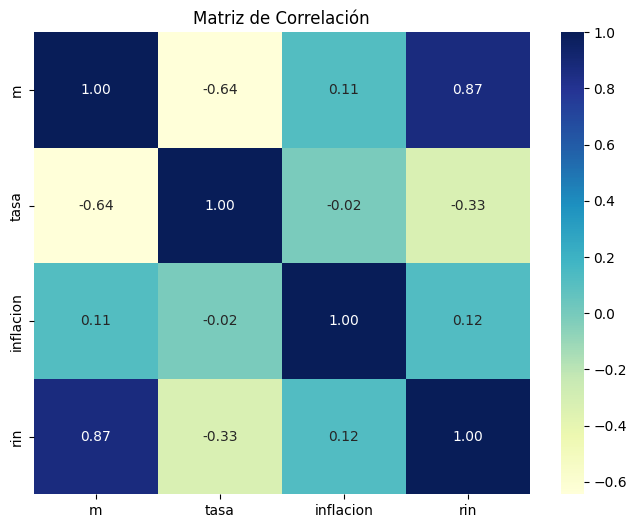

In [ ]:
## B) MATRIZ DE CORRELACION
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [8]:
## C) TRANSFORMAR LOS DATOS A LN
df["ln_m"] = np.log(df["m"])
df["ln_tasa"] = np.log(df["tasa"])
df["ln_inflacion"] = np.log(df["inflacion"].abs())
df["ln_rin"] = np.log(df["rin"])

df = df.drop(columns=["m", "tasa", "inflacion", "rin"])
print(df.head())

  tiempo       ln_m   ln_tasa  ln_inflacion     ln_rin
0  Ene10  11.627382  1.791742     -2.927031  10.444124
1  Feb10  11.642777  1.792054     -5.976141  10.463389
2  Mar10  11.653491  1.795852     -1.312594  10.470760
3  Abr10  11.654769  1.794156     -2.329236  10.464502
4  May10  11.671847  1.800243     -1.755412  10.451898


In [16]:
## C) ANALISIS DESCRIPTIVO
print(df.dtypes)
print("------------------------------")
print(df.isnull().sum())
print("------------------------------")
print(df.describe(include='all'))

tiempo           object
ln_m            float64
ln_tasa         float64
ln_inflacion    float64
ln_rin          float64
dtype: object
------------------------------
tiempo          0
ln_m            0
ln_tasa         0
ln_inflacion    0
ln_rin          0
dtype: int64
------------------------------
       tiempo        ln_m     ln_tasa  ln_inflacion      ln_rin
count     187  187.000000  187.000000    187.000000  187.000000
unique    187         NaN         NaN           NaN         NaN
top     Ene10         NaN         NaN           NaN         NaN
freq        1         NaN         NaN           NaN         NaN
mean      NaN   12.521706    1.970951     -2.007623   11.060993
std       NaN    0.437007    0.466296      1.228371    0.189367
min       NaN   11.627382    1.386616     -7.354387   10.444124
25%       NaN   12.210250    1.614592     -2.563102   11.012314
50%       NaN   12.506149    1.792490     -1.870583   11.077965
75%       NaN   12.988345    2.400601     -1.229748   11.2020

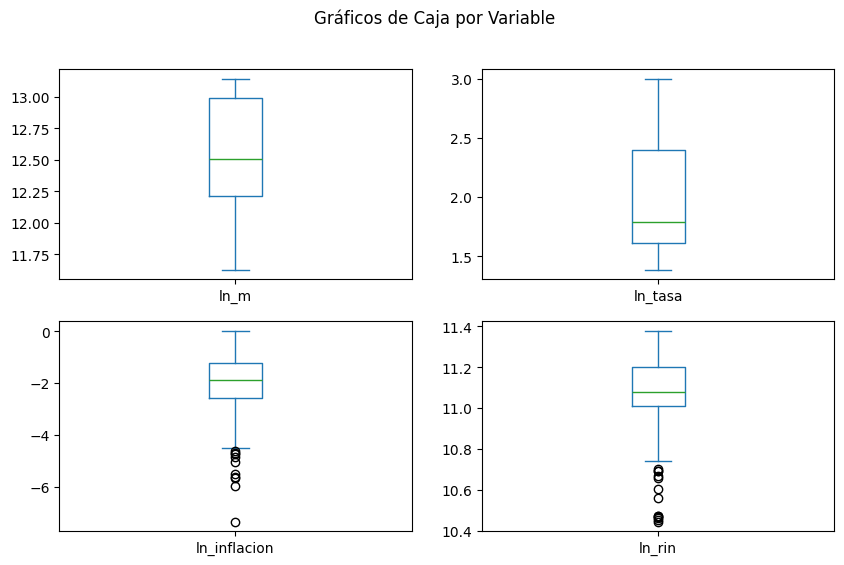

In [17]:
## D) GRAFICO DE CAJA
df.plot(kind='box', subplots=True, layout=(2,2), figsize=(10,6), sharex=False, sharey=False)
plt.suptitle("Gráficos de Caja por Variable")
plt.show()

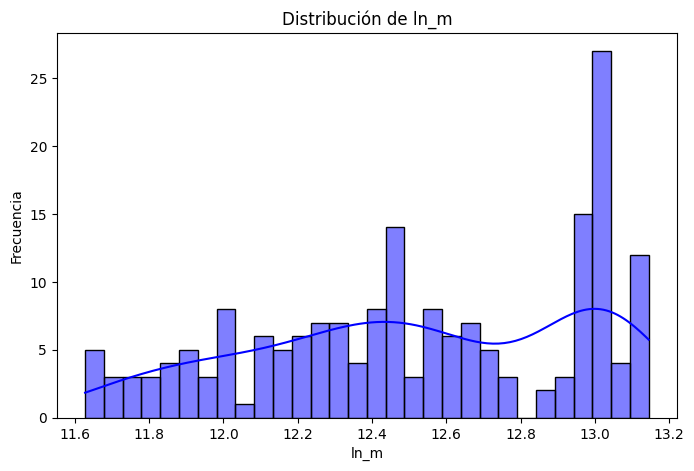

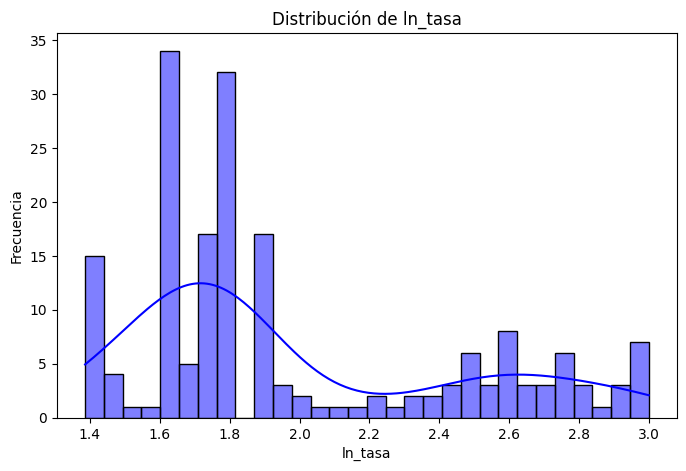

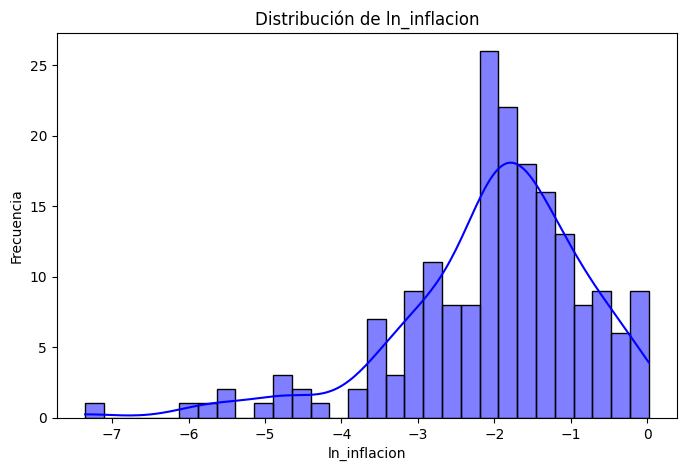

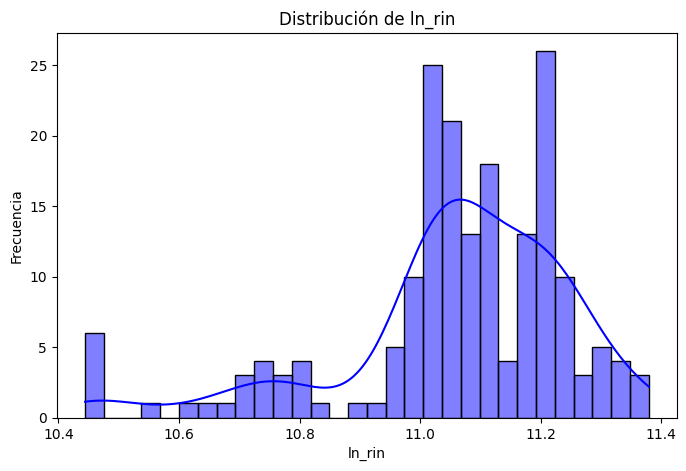

In [11]:
## Distribucion de las variables
for col in df.select_dtypes(include=['float64','int64']).columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

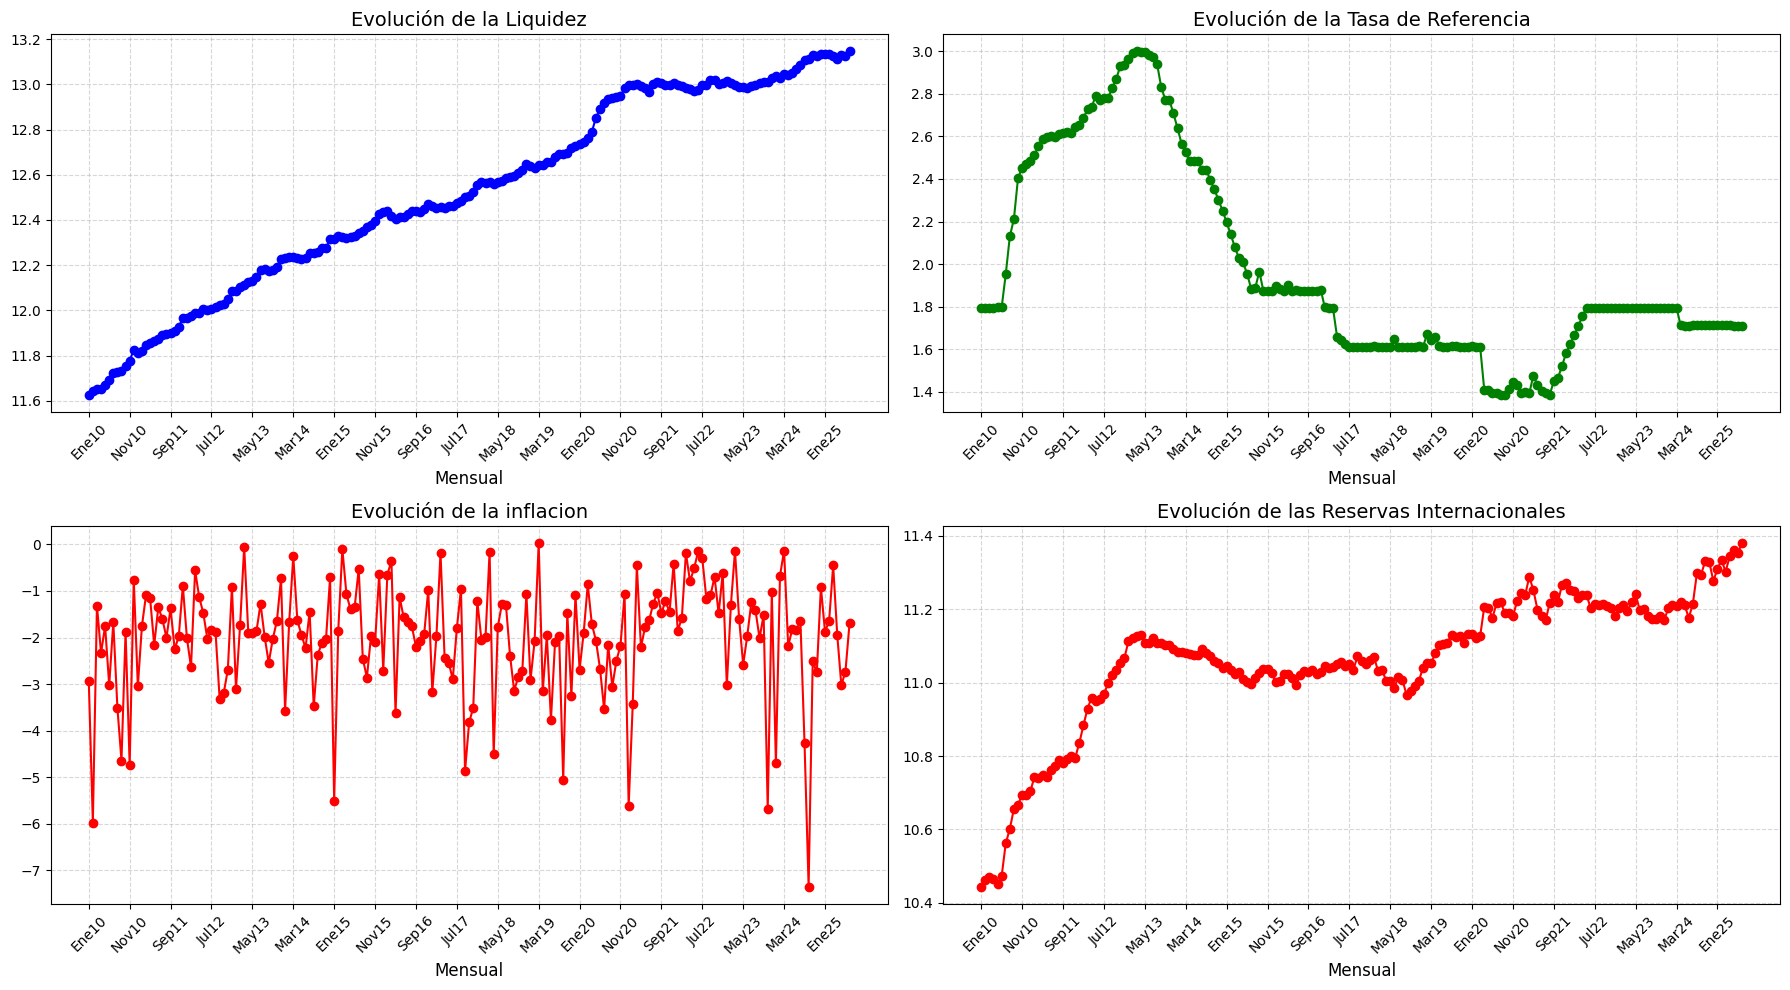

In [21]:
## E) ANALISIS DE LA SERIES EN EL TIEMPO

fig, axes = plt.subplots(2, 2, figsize=(18,10))

# Gráfico 1: Liquidez
axes[0,0].plot(df["tiempo"], df["ln_m"], marker="o", linestyle="-", color="blue")
axes[0,0].set_title("Evolución de la Liquidez", fontsize=14)
axes[0,0].set_xlabel("Mensual", fontsize=12)
axes[0,0].set_ylabel("", fontsize=12)
axes[0,0].grid(True, linestyle="--", alpha=0.5)
axes[0,0].set_xticks(df["tiempo"][::10])
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2: Tasa
axes[0,1].plot(df["tiempo"], df["ln_tasa"], marker="o", linestyle="-", color="green")
axes[0,1].set_title("Evolución de la Tasa de Referencia", fontsize=14)
axes[0,1].set_xlabel("Mensual", fontsize=12)
axes[0,1].set_ylabel("", fontsize=12)
axes[0,1].grid(True, linestyle="--", alpha=0.5)
axes[0,1].set_xticks(df["tiempo"][::10])
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico 3: IPC
axes[1,0].plot(df["tiempo"], df["ln_inflacion"], marker="o", linestyle="-", color="red")
axes[1,0].set_title("Evolución de la inflacion", fontsize=14)
axes[1,0].set_xlabel("Mensual", fontsize=12)
axes[1,0].set_ylabel("", fontsize=12)
axes[1,0].grid(True, linestyle="--", alpha=0.5)
axes[1,0].set_xticks(df["tiempo"][::10])
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4: RIN
axes[1,1].plot(df["tiempo"], df["ln_rin"], marker="o", linestyle="-", color="red")
axes[1,1].set_title("Evolución de las Reservas Internacionales", fontsize=14)
axes[1,1].set_xlabel("Mensual", fontsize=12)
axes[1,1].set_ylabel("", fontsize=12)
axes[1,1].grid(True, linestyle="--", alpha=0.5)
axes[1,1].set_xticks(df["tiempo"][::10])
axes[1,1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

# 5. Estimación del modelo

In [26]:
# Definir variables independientes y dependiente
X = df[["ln_tasa", "ln_inflacion", "ln_rin"]]
y = df["ln_m"]

# Agregar constante para el intercepto
X = sm.add_constant(X)

# Crear modelo y ajustar
modelo = sm.OLS(y, X).fit()

# Resumen del modelo
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                   ln_m   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1012.
Date:                Mon, 08 Sep 2025   Prob (F-statistic):          1.25e-113
Time:                        14:24:52   Log-Likelihood:                 158.02
No. Observations:                 187   AIC:                            -308.0
Df Residuals:                     183   BIC:                            -295.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.6623      0.502     -9.283   



* 📉 Tasa de referencia ↑ → Liquidez ↓ (efecto contractivo, muy fuerte y significativo).

* 📈 Inflación ↑ → Liquidez ↑ (efecto débil, poco significativo).

* 📈 RIN ↑ → Liquidez ↑ (efecto expansivo, fuerte y significativo).

# 6. Diagnósticos econométricos

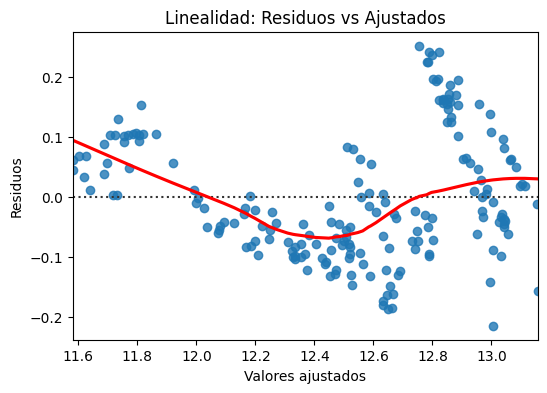

In [27]:
# 1. Linealidad (gráfico residuos vs valores ajustados)
plt.figure(figsize=(6,4))
sns.residplot(x=modelo.fittedvalues, y=modelo.resid, lowess=True, line_kws={"color":"red"})
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Linealidad: Residuos vs Ajustados")
plt.show()


Test Shapiro-Wilk:
Estadístico: 0.966139319951342  | p-value: 0.0001717707984245896
❌ No normalidad (se rechaza H0)


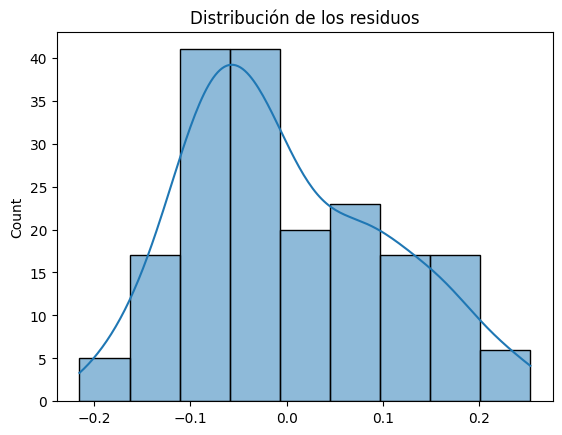

In [28]:
# 2. Normalidad de errores
# Shapiro-Wilk
stat_shapiro, p_shapiro = shapiro(modelo.resid)
print("\nTest Shapiro-Wilk:")
print("Estadístico:", stat_shapiro, " | p-value:", p_shapiro)
if p_shapiro > 0.05:
    print("✅ Normalidad (no se rechaza H0)")
else:
    print("❌ No normalidad (se rechaza H0)")

sns.histplot(modelo.resid, kde=True)
plt.title("Distribución de los residuos")
plt.show()

In [29]:
# 3. Homocedasticidad (Breusch-Pagan): Los errores tienen la misma varianza en todas las observaciones
bp_test = het_breuschpagan(modelo.resid, modelo.model.exog)
labels = ["LM Statistic","LM-Test p-value","F-Statistic","F-Test p-value"]
results = dict(zip(labels, bp_test))

print("\nTest de Breusch-Pagan (Homocedasticidad):")
print(results)

if results["LM-Test p-value"] > 0.05:
    print("✅ Se cumple homocedasticidad (no se rechaza H0).")
else:
    print("❌ No se cumple homocedasticidad (se rechaza H0).")


Test de Breusch-Pagan (Homocedasticidad):
{'LM Statistic': np.float64(9.914709513153886), 'LM-Test p-value': np.float64(0.01930522406285589), 'F-Statistic': np.float64(3.415288071864506), 'F-Test p-value': np.float64(0.018597030288089438)}
❌ No se cumple homocedasticidad (se rechaza H0).



Prueba Durbin-Watson:
Estadístico DW: 0.1433
Posible autocorrelación positiva de los residuos.


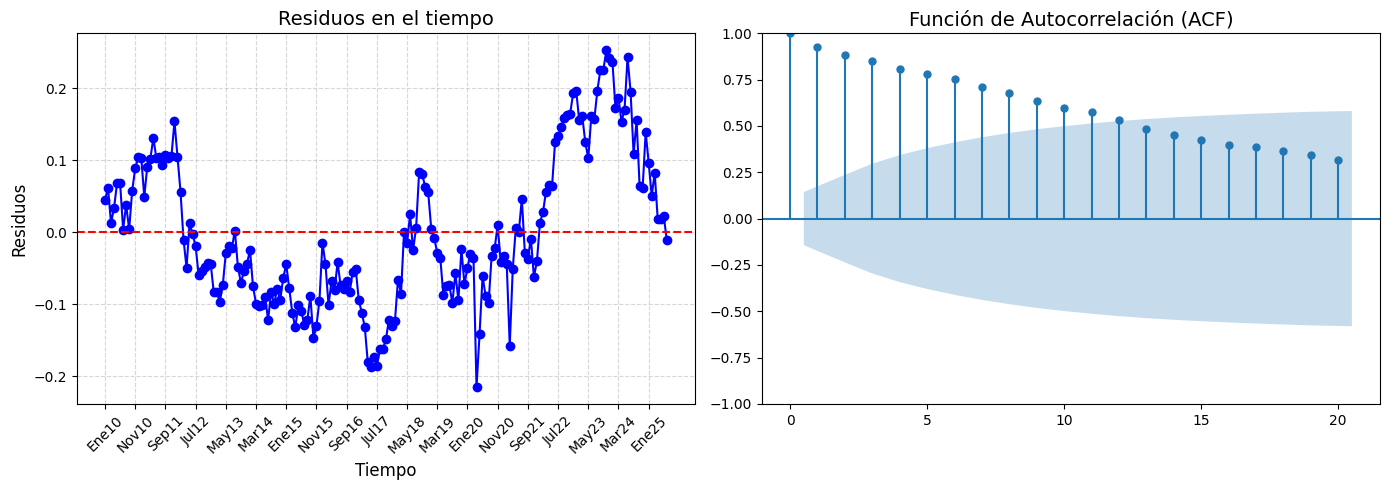

In [30]:
# 4. Durbin-Watson
dw_stat = durbin_watson(modelo.resid)

print("\nPrueba Durbin-Watson:")
print("Estadístico DW:", round(dw_stat, 4))

# Interpretación
if dw_stat < 1.5:
    print("Posible autocorrelación positiva de los residuos.")
elif dw_stat > 2.5:
    print("Posible autocorrelación negativa de los residuos.")
else:
    print("No hay evidencia fuerte de autocorrelación.")

# Crear figura con 2 gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===============================
# Gráfico 1: Residuos en el tiempo
axes[0].plot(df["tiempo"], modelo.resid, marker="o", linestyle="-", color="blue")
axes[0].axhline(y=0, color="red", linestyle="--")
axes[0].set_title("Residuos en el tiempo", fontsize=14)
axes[0].set_xlabel("Tiempo", fontsize=12)
axes[0].set_ylabel("Residuos", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.5)


axes[0].set_xticks(df["tiempo"][::10])
axes[0].tick_params(axis='x', rotation=45)

# ===============================
# Gráfico 2: Autocorrelación (ACF)
sm.graphics.tsa.plot_acf(modelo.resid, lags=20, ax=axes[1])
axes[1].set_title("Función de Autocorrelación (ACF)", fontsize=14)

plt.tight_layout()
plt.show()

# 7. Interpretación económica

Constante (-4.6623, p=0.000): sin interpretación económica directa, solo ajusta el modelo.

* Tasa de referencia (β = -0.4286, p=0.000): Efecto negativo y significativo.

↑ 1% tasa → ↓ 0.43% liquidez.

El BCRP restringe el dinero circulante al elevar la tasa.

* Inflación (β = 0.0105, p=0.100): Efecto positivo pero débil (no significativo al 5%).

↑ inflación → ligera ↑ en liquidez, pero sin robustez estadística.

* RIN (β = 1.6318, p=0.000): Efecto positivo y fuerte.

↑ 1% RIN → ↑ 1.63% liquidez.

Mayores reservas fortalecen la capacidad de expansión monetaria.